In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
root_audios = f"{root}/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Complementary_Files/df_grabadoras_reg.csv"
root_clusters = f"{root}/temporal/clusters"
root_vggish = f"{root}/vggish/Features_vggish"
ecological_integrity = f"{root}/Complementary_Files/Indice_Integridad_Ecologica.xlsx"

audios = pd.read_csv(root_audios, index_col=0)
recorders = pd.read_csv(root_recorders, sep=";")
ei  = pd.read_excel(ecological_integrity)

audios.set_index("Filename", inplace=True)

## VGGISH Features and Labels

X_vgg = torch.load(f"{root_vggish}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish}/vggish_filenames.pth")

y_vgg = [i.split('/')[6:8] for i in y_vgg]

for i in range(len(y_vgg)):
    y_vgg[i] = f"{y_vgg[i][0]}"


X_add = []
for i in range(len(X_vgg)):
    if(X_vgg[i].shape == torch.Size([62, 128])):
        X_add.append(i)
        
X_vgg2 = []
y_vgg2 = []
for i, value in enumerate(X_add):
    X_vgg2.append(X_vgg[value])
    y_vgg2.append(y_vgg[value])
X_vgg2 = torch.stack(X_vgg2)
X_vgg2 = X_vgg2.numpy()
X_vgg2 = X_vgg2.reshape(X_vgg2.shape[0], X_vgg2.shape[1]*X_vgg2.shape[2])

df_vgg = pd.DataFrame(X_vgg2)
df_vgg["y"] = y_vgg2
df_vgg
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['Habitat'] = df_vgg.index.map(audios['Habitat'])
df_vgg['Rain_Intesity'] = df_vgg.index.map(audios['Rain_Intesity'])


def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_vgg[['location', 'day', 'hour']] =df_vgg['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_vgg['hour_stage'] =df_vgg['hour'].apply(define_hour_stage)
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['Habitat'] = df_vgg.index.map(audios['Habitat'])
df_vgg = df_vgg[df_vgg['Rain_Intesity'] == 0]

df_vgg.to_csv('df_vgg.csv', index=False)

In [5]:
df_vgg = pd.read_csv("New_df_vgg.csv")
df_vgg.set_index("y", inplace=True)

## All classification covers

Accuracy: 0.8548625480342891
f1: 0.7879873725683304
recall 0.7581487034260648
[[0.96457327 0.03542673]
 [0.44827586 0.55172414]]
[[2396   88]
 [ 403  496]]


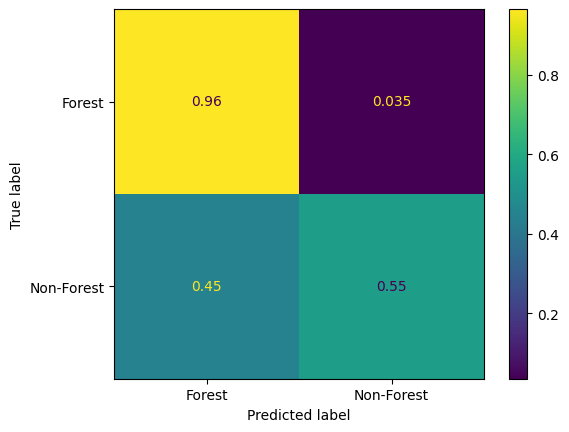

In [15]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = np.asarray(df_vgg.iloc[:,0:7936])
y = np.asarray(df_vgg.loc[:,"Habitat"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["Forest", "Non-Forest"])
cm_display.plot()
plt.show()

## All classification Hours

Accuracy: 0.8530889742831806
f1: 0.8098394250017013
recall 0.7983810301466338
[[0.91734861 0.04091653 0.04173486]
 [0.21705426 0.54573643 0.2372093 ]
 [0.03957784 0.02836412 0.93205805]]
[[1121   50   51]
 [ 140  352  153]
 [  60   43 1413]]


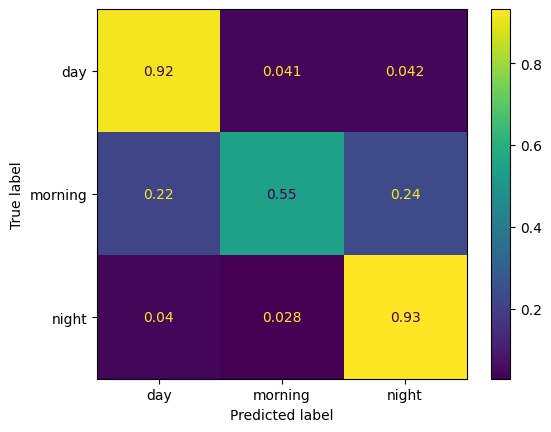

In [14]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_vgg.iloc[:,0:7936])
y = np.asarray(df_vgg.loc[:,"hour_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()


## Cover classification

In [80]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_covers = []
f1_scores_vgg_covers = []
recalls_vgg_covers = []
df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_vgg[df_vgg['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:7936])
    y = np.asarray(df_day.loc[:,"Habitat"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_covers.append(accuracy)
    f1_scores_vgg_covers.append(f1_score)
    recalls_vgg_covers.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_vgg_covers.npy", accuracies_vgg_covers)
np.save(f"{root}/temporal/classification_results/f1_scores_vgg_covers.npy", f1_scores_vgg_covers)
np.save(f"{root}/temporal/classification_results/recalls_vgg_covers.npy", recalls_vgg_covers)

Accuracy: 0.8974358974358975
f1: 0.6388888888888888
recall 0.6022884882108183
Accuracy: 0.8666666666666667
f1: 0.6131578947368421
recall 0.5882352941176471
Accuracy: 0.9038461538461539
f1: 0.7644927536231885
recall 0.7130681818181819
Accuracy: 0.918918918918919
f1: 0.7279411764705883
recall 0.6666666666666666
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 0.9431818181818182
f1: 0.8834437086092716
recall 0.8333333333333333
Accuracy: 0.83
f1: 0.8062678062678064
recall 0.7942708333333333
Accuracy: 0.925531914893617
f1: 0.9235861107885264
recall 0.9251748251748252
Accuracy: 0.8608695652173913
f1: 0.8483849703361899
recall 0.8369565217391304
Accuracy: 0.9058823529411765
f1: 0.896969696969697
recall 0.8873820754716981
Accuracy: 0.8924731182795699
f1: 0.888755980861244
recall 0.8832082551594747
Accuracy: 0.918918918918919
f1: 0.9068183938065479
recall 0.8875
Accuracy

## Hour Stage Classification

In [87]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_hours = []
f1_scores_vgg_hours = []
recalls_vgg_hours = []
df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_vgg[df_vgg['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:7936])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_hours.append(accuracy)
    f1_scores_vgg_hours.append(f1_score)
    recalls_vgg_hours.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_vgg_hours.npy", accuracies_vgg_hours)
np.save(f"{root}/temporal/classification_results/f1_scores_vgg_hours.npy", f1_scores_vgg_hours)
np.save(f"{root}/temporal/classification_results/recalls_vgg_hours.npy", recalls_vgg_hours)

Accuracy: 0.811965811965812
f1: 0.7510025196067994
recall 0.7479363286816701
Accuracy: 0.8476190476190476
f1: 0.761431623931624
recall 0.7443101745508617
Accuracy: 0.8269230769230769
f1: 0.7272804774083547
recall 0.7223635400105989
Accuracy: 0.8783783783783784
f1: 0.8762270593256508
recall 0.8904991948470209
Accuracy: 0.8615384615384616
f1: 0.6091575091575091
recall 0.6527777777777778
Accuracy: 0.8695652173913043
f1: 0.8426353833392581
recall 0.8285797260943996
Accuracy: 0.8275862068965517
f1: 0.7042600394862714
recall 0.7058156028368794
Accuracy: 0.9130434782608695
f1: 0.8929637173171656
recall 0.880221653878943
Accuracy: 0.8695652173913043
f1: 0.8459217644610902
recall 0.8427015250544662
Accuracy: 0.9090909090909091
f1: 0.8135466952738543
recall 0.7858156028368795
Accuracy: 0.87
f1: 0.8107585427173056
recall 0.8042328042328042
Accuracy: 0.9148936170212766
f1: 0.8456105280692987
recall 0.8095238095238096
Accuracy: 0.8695652173913043
f1: 0.850088431127757
recall 0.8440016103059582
Accu